<font size=5 color=#A52A2A >Optimize "Choose The Best Movie" Bandit Problem using Thompson Sampling, e-greedy, UBC, and random sampling.

In the code below, we will use the Bernoulli Multi-armed Bandits Problem to simulate choosing the best movie, and also use Thompson Sampling, e-greedy, UBC, and random sampling to optimize this bantis problem.

<font size=4 >Creating the multi-armed bandit Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

<font size=4 >Thompson sampling

How Thompson Sampling Solved the Problem of Picking the Best Movies:
1. Estimate the parameters of a pair of beta distributions for each movie.
2. Randomly sample from the beta distribution of each movie before each trial to obtain the corresponding conversion rate 3. Select the movie with the largest conversion rate
4. Update the beta distribution parameters of the movie according to whether the user converts the movie. Specifically, if it is converted, add 1, otherwise add 1.

In [19]:
class ThompsonBeta():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

<font size=4 >Random Sampling

In [2]:
class RandomSampling():
    
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
  
  @staticmethod
  def name():
    return 'random-sampling'
  
  def get_action(self):
    action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    return reward, regret

<font size=4 >E-Greedy
    
ϵ-greedy is a commonly used strategy in the trade-off between exploitation and exploration. It means that when the agent makes a decision, there is a small probability of a positive number ϵ ( < 1 ) to randomly select an unknown action, and the remaining probability of 1 − ϵ selects the action with the largest action value among the existing actions.

In [4]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 

<font size=4 >UCB
    
 The Upper Confidence Bound (UCB) algorithm is often phrased as “optimism in the face of uncertainty.” That is, if a bandit has the potential to be the best we should try it. As one tries bandits more and more the uncertainty around the estimate of its payout shrinks. The algorithm allocates exploratory effort to actions that might be optimal and are in this sense "optimistic."

In [5]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

<font size=4 >Simulating the environment and experiments

In [6]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.ylabel("Regret")
  plt.xlabel("Timesteps")
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, ThompsonBeta, RandomSampling]
 
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

<font size=5 color=#A52A2A >Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 

Random sampling: no hyperparameters.
Thompson Sampling: No hyperparameters.
e-greedy : Epsilon is a parameter.
UCB : Confidence (ucb_c) is a parameter.

The hyperparameters are important by running two experiments with different epsilon and c. We find that the non-Thompson agents benefit from parameter tuning, but the Thompson agents work well out of the box.

For this first experiment, we aim for a standard setup inspired by the bandit testbed in Chapter 2 of [2]. Set e=0.1 for the e-greedy algorithm and c=2 for UCB. As seen in the chart below, the Thompson and e-greedy agents quickly converge to a stable regret value after only 200 steps. UCB agent on the other hand is declining very slowly, lagging behind his two other agents and continuing its downward trend at step 1000.

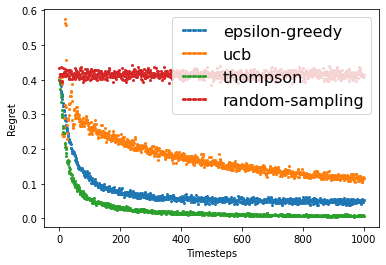

In [7]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

Being greedier

After fiddling with UCB's c parameter, we can see that if it is set to 0.1, it quickly converges to a low regret value, after only a few dozen steps and now outperforms e-greedy with very little variance. Note that at first it outperforms Thompson, but not in the long run. Decreasing UCB's c basically decreased the "premium" the agent adds to uncertainty. This encourages UCB to be more "greedy", hence why it converges quickly. Yet it still does not outperform Thompson. Given this intuition, we also make e-greedy greedier, decreasing its hyperparameter to 0.03. We can see that after 1000 steps, it does outperform the previous e-greedy, but only marginally. Also, this comes at the cost of converging much more slowly. We do not observe the massive swing as observed with UCB, even if we continue to lower e. It's possible that given only 10 actions, being greedy is a better solution, and exploring is costly and unnecessary.

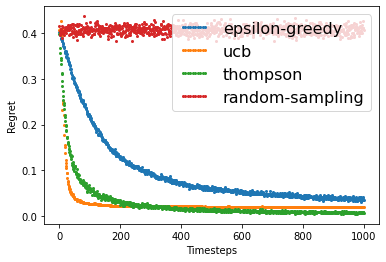

In [8]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

<font size=5 color=#A52A2A >How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points)

Large action space

In this setting, we increase the number of actions from 10 to 200, leaving the other parameters equal to our baseline. The e-greedy agent barely budges in its learning pattern when compared to the baseline. The Thompson agent very slowly, but surely, decreases regret to eventually outperform -greedy around step 700, another vote of confidence for Thompson. On the other hand, UCB is drastically unstable and diverges. This behaviour is not only due to the increase in action space, but due to the fact that the Bernouilli reward probabilities are so close to each other. Recall that regret is calculated as the difference between the optimal θ and the action θ. Since the true θ are sampled from a uniform distribution, they are evenly spread between 0 and 1. The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action. Thompson and UCB, on the other hand, with their emphasis on exploration, give a high premium to exploring actions not yet seen. Since there are so many actions, and since the mean rewards are evenly distributed between 0 and 1, there is a high cost of constantly exploring actions with rewards close to 0. Noticeably, the Thompson algorithm is incredibly stable across time, despite the large action space. Due to its sampling nature, it has a lower probability than UCB of constantly taking suboptimal actions.

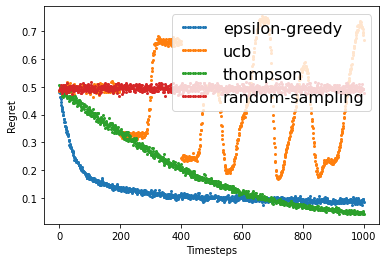

In [9]:
# Experiment 3
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

We now lower UCB's c variable and observe a dramatic increase in stability, which even leads it to outperform all other algorithms. However, the Thompson agent still seems to be on a decreasing regret trend around 1000 steps without having converged, in between e-greedy and UCB.

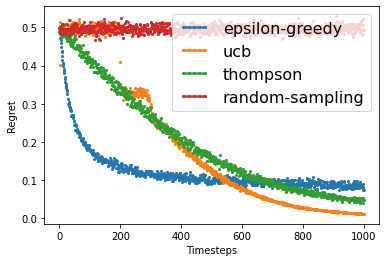

In [10]:
# Experiment 4
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

In the graph below, increasing the timesteps to 3000 confirms that Thompson and UCB closely converge.

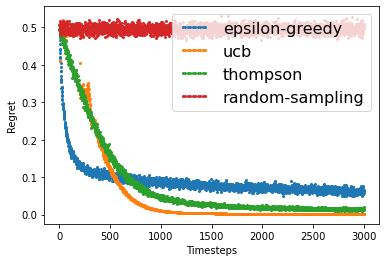

In [11]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)


<font size=5 color=#A52A2A >How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 
    
Non-stationarity

We now reset our parameters to the baseline settings: 10-arm bandit,e = 0.1 and UCB-c value of 2. However, we now set the environment to being non-stationary. Actually, after every 100 steps, the bandit resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. Below we see a clear jump in regret every time the true bandit parameters are resampled (every 100 steps). While the e-greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. We confirm this in the next experiment.

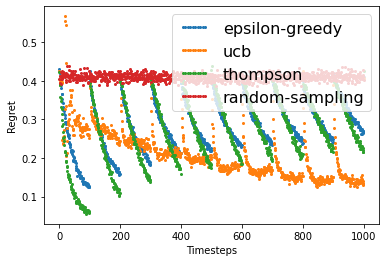

In [12]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

We now set UCB's c parameter to 0.1 as we did in Experiment 2. Due to Experiment 2's setup, we concluded a greedier version of UCB would perform better in that setup, which it did. In the current setup, we can observe that the greedy UCB performs quite poorly and much like the other algorithms. Since we prefer a more exploratory algorithm, we fine tune e-greedy to be much less greedy and observe that it does not perform well. In fact, after trying for e {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9}, e-greedy performs the same as in the chart below.

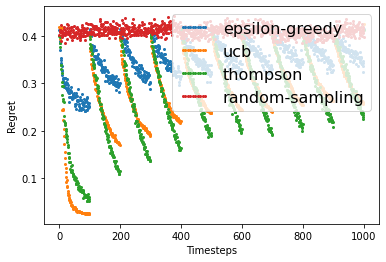

In [13]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.6
ucb_c = 0.1
stationary=False
experiment(arm_count)

We have seen the advantages and disadvantages of various algorithms. The Thompson algorithm has been shown to perform quite well in various settings without any necessary parameter tuning to boot. In some cases, UCB performed close to Thompson, but required fine tuning. Exceptionally, UCB dealt better than Thompson in the non-stationary setup, but only after tuning its hyperparameter. Notably, in no cases was e-greedy the best performing agent.



<font size=5 color=#A52A2A >When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

1.Random Sampling: Sampling is random, so it always exploring. 
    
2.Thompson Sampling: Will not stop searching until the simulation is complete.
    
3.e-greedy and UCB: Use epsilon % time and don't stop searching until the simulation is complete. 

Exploration vs. Exploitation Tradeoff: It's important to balance exploration and exploitation for maximum rewards.



<font size=5 color=#A52A2A >How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points)

1.Random sampling: Totally random, so Random sampling don't remember your past behavior.
    
2.Thompson Sampling: Remember past actions as long as they run on the beta release used to create the action.
    
3.e-greedy : Same as Thompson sampling because it requires available historical behavioral data.
    
4.UCB : Same as e-greedy.
    


<font size=5 color=#A52A2A >Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)


In [14]:
import math
class ThompsonNormal():
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.mean = np.zeros(self.arm_count)
    self.std = np.zeros(self.arm_count)
    self.n = np.zeros(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.n[arm]+=1
    old_mean = self.mean[arm]
    new_mean = (self.mean[arm]*(self.n[arm]-1) + reward)/self.n[arm]
    self.mean[arm] = new_mean

    old_var = np.power(self.std[arm],2)
    if((self.n[arm]-1)!=0):
      new_var = ((self.n[arm]-2)/(self.n[arm]-1))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    else:
      new_var = ((self.n[arm]-2))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    self.std[arm] = math.sqrt(new_var)

  @staticmethod
  def name():
    return 'thompson-normal'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.normal(self.mean, self.std)
    return theta.argmax()

def experiment_compare_thompson(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [ThompsonBeta, ThompsonNormal]
 
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

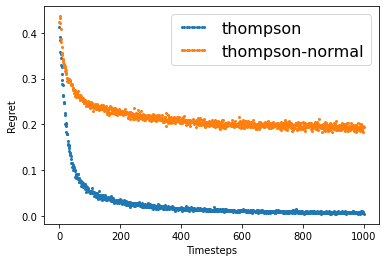

In [18]:
# Experiment 8
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment_compare_thompson(arm_count)

Large Action Space comparison

In [ ]:
# Experiment 9 :
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment_compare_thompson(arm_count)


<font size=5 color=#A52A2A >What code is yours and what have you adapted? (10 Points)
    
    


Added random sampling section code, modify the Thompson Sampling to run with a different distribution, based on cite references.


<font size=5 color=#A52A2A >References

[1]: Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017).

[2]: Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.
    
[3]: Andre Cianflone. Thompson sampling, https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb 
    
[4]: Xiaoshi. Machine learning python random sampling random sampling code, https://blog.csdn.net/u013288190/article/details/124337162
    
[5]: Dong Wang. From Thompson Sampling to reinforcement learning, the multi-armed bandit problem, https://yaoyaowd.medium.com/%E4%BB%8Ethompson-sampling%E5%88%B0%E5%A2%9E%E5%BC%BA%E5%AD%A6%E4%B9%A0-%E5%86%8D%E8%B0%88%E5%A4%9A%E8%87%82%E8%80%81%E8%99%8E%E6%9C%BA%E9%97%AE%E9%A2%98-23a48953bd30
    
 
<font size=5 color=#A52A2A >Licensing
    
Copyright 2022 Yiqing Wang

Persons who have obtained a copy of the software and associated documentation files may use the software free of charge without restriction. Publish, distribute, sublicense and/or sell copies of the software, subject to the following conditions:

THIS SOFTWARE IS PROVIDED "AS IS" WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT WARRANTIES. 
    
In no event shall the author or copyright holder be liable for any claim, damage or other liability, whether in contract, tort or otherwise, arising out of or in connection with the software or its use or other dealings. software.
